In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import matplotlib.ticker as mtick

import jax
from jax import random 
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from censored_demand.rental_model import PoissonDemandInventory, MultinomialDemandInventory
from censored_demand.plotting import plot_rentals

az.style.use("arviz-darkgrid")
SEED = 99

# Modeling Anything With First Principles: Inventory Demand under extreme stockouts

__The Problem:__ You work at a clothing rental service that is suffering from high periods of churn. You've found that stockouts are one of the biggest reasons for churn - despite having plenty of products to choose from, products tend to be stocked 60-80% of the time. __How can we determine how much stock to reorder?__

The idea of this project is to borrow ideas from first principles modeling - basically think about the data generating process and model each step of it. This example borrows ideas from discrete choice literature, survival analysis, demand forecasting, and simulation. 

Products with extreme stockouts have misleading demand estimates under classic demand models. The basis of these ideas is really simple. If we only have 5 units of a product in stock, and we saw 5 sales (or rentals in this case) that day, then we know that demand is atleast 5 rentals. Typical demand modeling might only look at the count of rentals each day, while censored demand modeling would look at both rental counts and stock levels, and incoporate both of these pieces of information. 

The idea is to start simple(-ish) and add complexity. We'll first model a single product and test different ordering policies, and then begin modeling multiple products. 

# Part 1: Looking at the data

---

We have two datasets:
 * `rentals` showing rental events and when those rentals were returned for a single product
 * `stock` showing available stock levels for that product over time

Remember, this is a rental product, so units flow back and forth between inventory and customers.

In [2]:
stock = (pd.read_csv("data/stock_levels.csv")
         .assign(date=lambda d: pd.to_datetime(d.date))
        )
stock.head()

,product_id,date,starting_units,ending_units
0,product_0,2022-04-01,110.0,109.0
1,product_0,2022-04-02,109.0,108.0
2,product_0,2022-04-03,108.0,107.0
3,product_0,2022-04-04,107.0,106.0
4,product_0,2022-04-05,106.0,105.0


In [3]:
rentals = (pd.read_csv("data/rentals.csv")
           .assign(date=lambda d: pd.to_datetime(d.date))
          )
           
rentals.head()

,rental_id,date,return_date,product_id
0,7ee46d21-bf37-45a9-a03d-3cc36e08d422,2022-04-01,2022-05-12,product_0
1,cfefc50c-178d-4666-a97b-608d37cb771f,2022-04-02,2022-04-18,product_0
2,53bcc895-3f56-4c2c-8046-4bbda06848e6,2022-04-03,2022-04-09,product_0
3,e0381b64-2001-4f84-957f-3b864a7dcb99,2022-04-04,2022-06-07,product_0
4,422f73f1-ba66-4cb2-94a3-cd314aea9fd5,2022-04-05,2022-05-05,product_0


In [4]:
purchases = (pd.read_csv("data/product_purchases.csv")
           .assign(date=lambda d: pd.to_datetime(d.date))
          )    
purchases.head()

,product_id,units,date,order_type
0,product_0,110.0,2022-04-01,new_product
1,product_1,60.0,2022-04-01,new_product
2,product_2,90.0,2022-04-01,new_product
3,product_3,110.0,2022-04-01,new_product
4,product_4,160.0,2022-04-01,new_product


Lets convert the rental data to time series data and see what it looks like

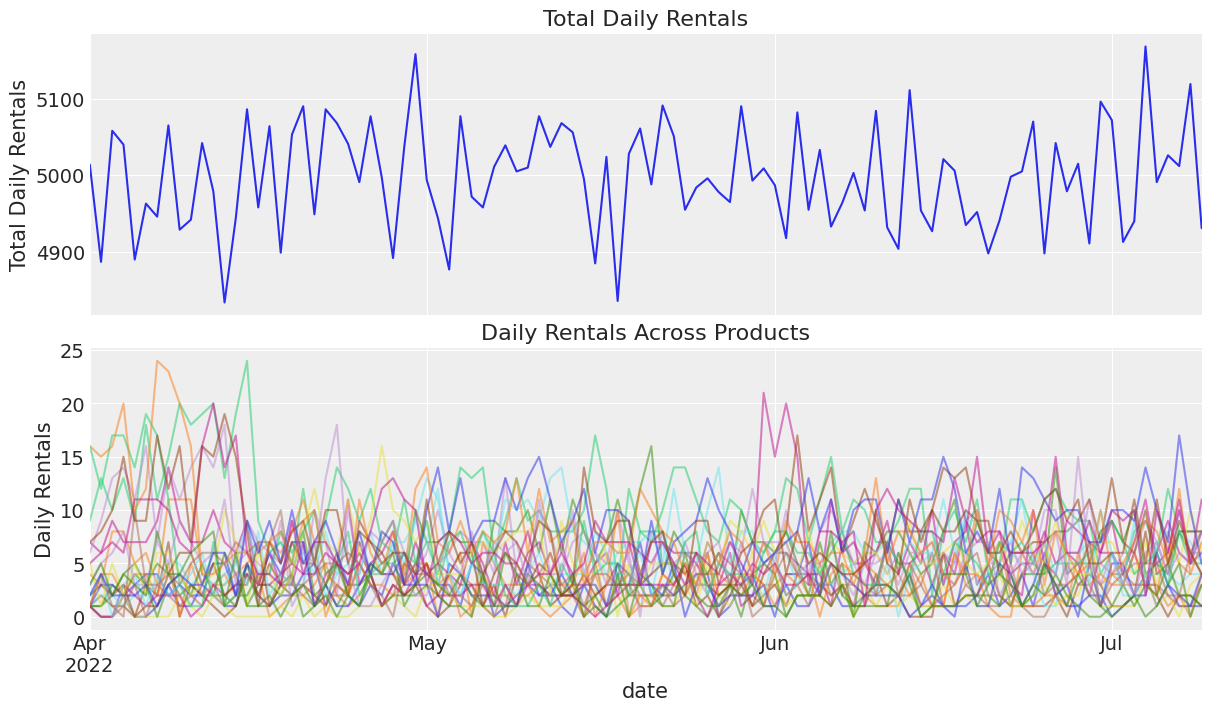

In [5]:
def rental_events_to_ts(rentals, freq='D'):
    return (rentals
            .groupby("product_id")
            .resample(freq,on='date')[['rental_id']].count()
            .set_axis(['rentals'],axis=1)
           )
    

daily_rentals = rentals.pipe(rental_events_to_ts, freq='D')

fig, ax = plt.subplots(2,1,figsize=(12,7),sharex=True)

ax[0].set(ylabel='Total Daily Rentals', xlabel='Date', title='Total Daily Rentals')
daily_rentals.groupby("date").sum().rentals.plot(ax=ax[0])

ax[1].set(ylabel='Daily Rentals', xlabel='Date', title='Daily Rentals Across Products')
sample_idxs = np.random.choice(1000, size=25, replace=False)
daily_rentals.unstack(0).iloc[:,sample_idxs].plot(ax=ax[1], alpha=0.5,legend=None)

plt.show()

It looks like theres typically 0-15 rentals per day for a given product, and there are typically 5000 rentals each day.

Looking at the distribution of total rentals across products, we see that its mildly long-tailed

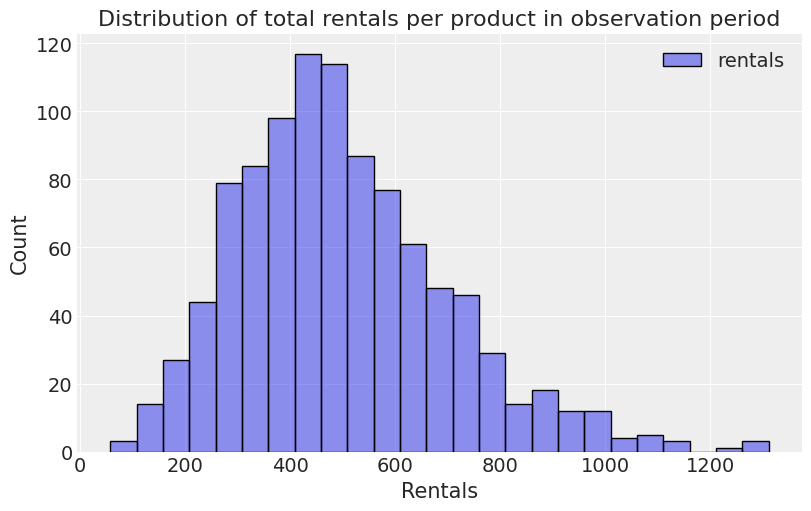

In [6]:
fig, ax = plt.subplots(1,1,figsize=(8,5),sharex=True)

ax.set(title='Distribution of total rentals per product in observation period', xlabel='Rentals')
sns.histplot( daily_rentals.groupby("product_id").sum(),ax=ax )
plt.show()

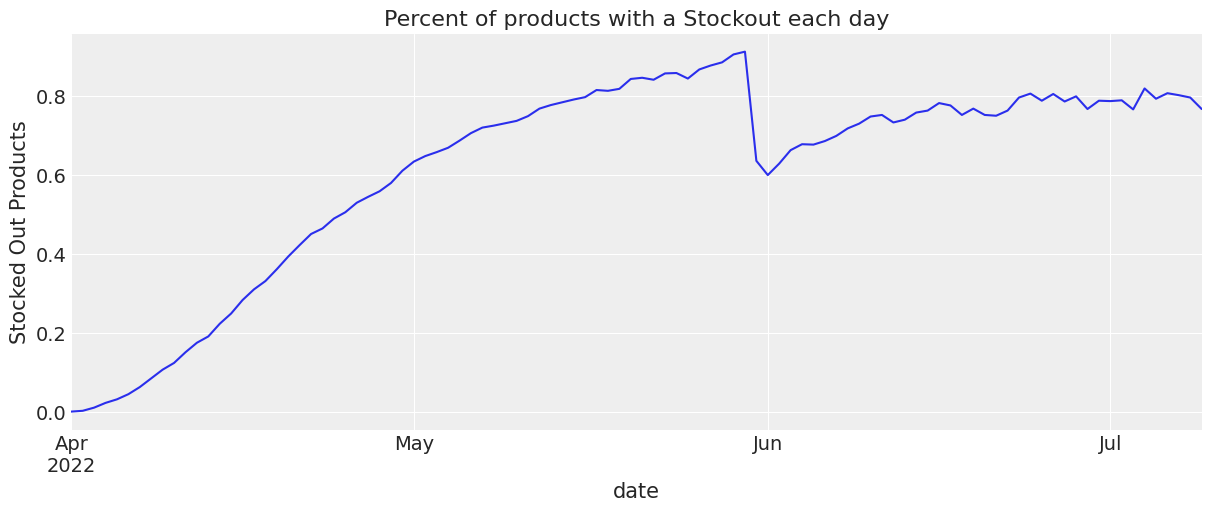

In [7]:
fig, ax = plt.subplots(1,1,figsize=(12,5))
(stock
 .assign(stockout_rate=lambda d: d.ending_units==0)
 .groupby("date").stockout_rate.mean()
 .plot(ylabel='Stocked Out Products',title='Percent of products with a Stockout each day'))

plt.show()

We cam also see that stockouts are extremely prevalent - on a given day, up to 55% of products were stocked out. A recent reorder helped a little but not enough. How can we reduce the stockout problem and reorder accordingly?

# Starting simple: Looking at a single product
We're going to start with a single product and see if we can come up with a system that informs us how many units we should reorder


/var/folders/vr/0jhy9tx52_s6tvbfbyppgn580000gn/T/ipykernel_58656/1171203775.py:31: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


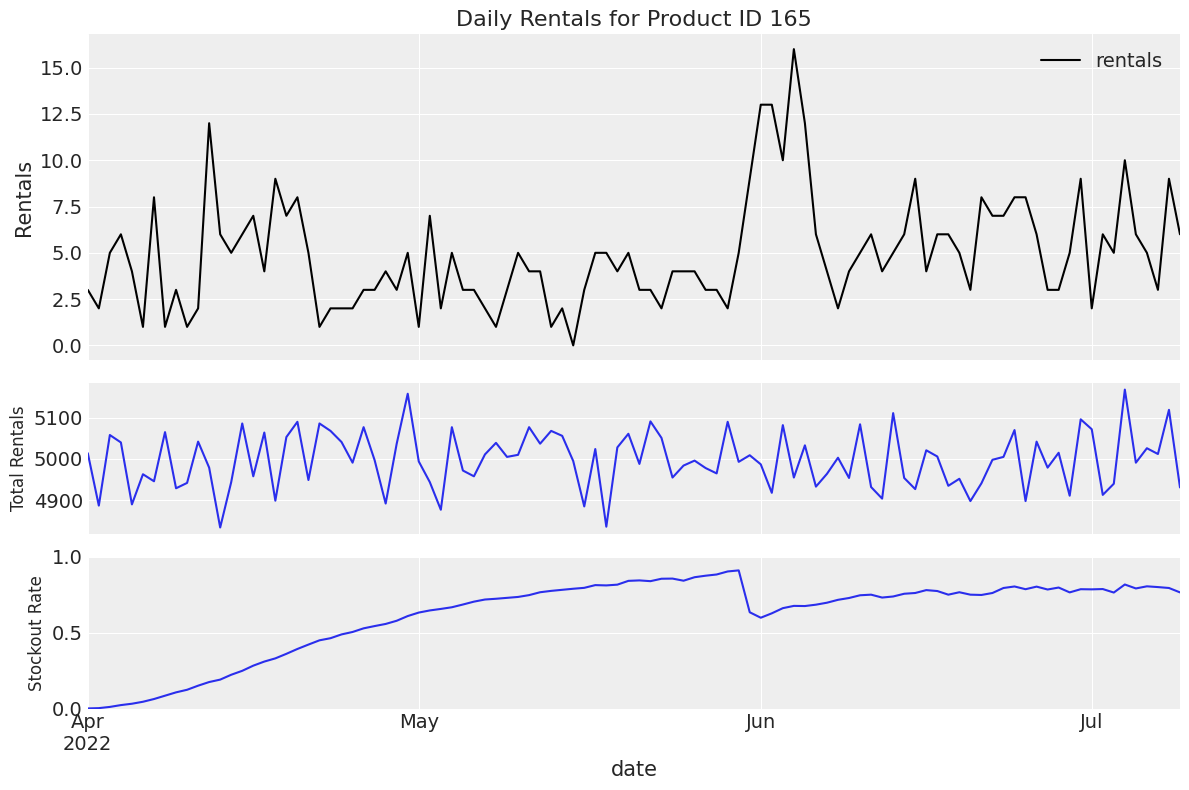

In [8]:
# j = 493
j=165
reorder_date = (
    purchases
    .query(f"product_id=='product_{j}'")
    .query("order_type=='reorder'")
    .date.min()
)


fig, ax = plt.subplot_mosaic(
    """
    AAA
    AAA
    BBB
    CCC
    """,figsize=(12,8),sharex=True)

ax['A'].set_title(f"Daily Rentals for Product ID {j}")
daily_rentals.loc[f'product_{j}'].plot(ax=ax['A'], color='k',ylabel='Rentals')
daily_rentals.groupby("date").sum().rentals.rename("total_rentals").plot(ax=ax['B'],ylabel='Total Rentals')
ax['B'].set_ylabel("Total Rentals", fontsize=12)

(stock
 .assign(stockout_rate=lambda d: d.ending_units==0)
 .groupby("date").stockout_rate.mean()
 .plot(ax=ax['C']))
ax['C'].set_ylabel("Stockout Rate", fontsize=12)
ax['C'].set_ylim(0,1)

plt.tight_layout()


As shown above, just looking at a time series of rentals each day is a bit confusing - soon after the product is published there's a lot of rentals, which then drop off quickly. Then around June, theres a giant spike in rentals that drops off quickly again. When looking at a simple covariate, the total number of rentals that occur every day, there's no obvious relationship - aka it seems like the spike in demand was moreso just for this product, not for all products. 

When we look at the overall stockout rate over time, it looks like the stockout rate drops at the same time demand increases for Product ID 493. 

Lets join stock data to rental data and see whats happening for this product

In [9]:
# (
#     daily_rentals.groupby("product_id")[['rentals','stockout']].mean().sort_values(by='rentals')
#     .loc[lambda d: d.index.isin(purchases.query("order_type=='reorder'").product_id.unique())].tail(50)
# )

In [10]:
daily_rentals = (rentals.pipe(rental_events_to_ts, freq='D')
                 .merge(stock, on=['product_id', 'date'])
                 .assign(stockout=lambda d: 1*(d.ending_units==0))
                 .assign(total_stockout_rate=lambda d: d.groupby("date").stockout.transform("mean")) 
                 .assign(total_rentals=lambda d: d.groupby("date").rentals.transform("sum"))
                 .set_index(['product_id', "date"])
                )

daily_rentals.head()

rentals  starting_units  ending_units  stockout  \
product_id date                                                          
product_0  2022-04-01        1           110.0         109.0         0   
           2022-04-02        1           109.0         108.0         0   
           2022-04-03        1           108.0         107.0         0   
           2022-04-04        1           107.0         106.0         0   
           2022-04-05        1           106.0         105.0         0   

                       total_stockout_rate  total_rentals  
product_id date                                            
product_0  2022-04-01             0.001122           5014  
           2022-04-02             0.003125           4887  
           2022-04-03             0.011190           5058  
           2022-04-04             0.023209           5040  
           2022-04-05             0.032193           4890

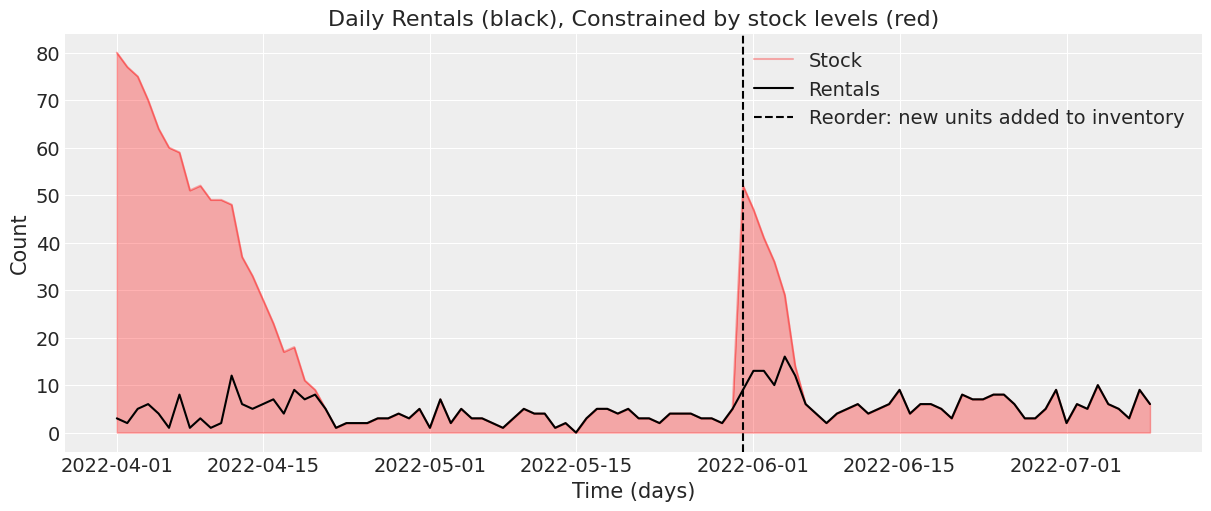

In [11]:
ax = plot_rentals(
    daily_rentals = daily_rentals.loc[f'product_{j}'].rentals, 
    daily_stock = daily_rentals.loc[f'product_{j}'].starting_units)

ax.axvline(reorder_date, color='k', ls='--', label='Reorder: new units added to inventory')
plt.legend()
plt.show()

For most of the days in the product's lifetime, there are as many rentals as there are units available. This indicates we're probably understocked - if we had more stock available, we'd likely observe more rental demand. 

This is also apparent in the overstocked periods - at the start of the products lifetime there tends to be more rentals. There's also a __reorder__ that happens at t=60, where the business procured new units of that product to rent out to customers. We can see that there's a jump in observed rentals 

It's time to introduce a key concept - the difference between rental demand and observed rentals. 
 * __Rental demand__ is the true demand to rent the product each day.
 * __Observed rentals__ are the number of rentals we actually observe in the data, after random noise is added to demand and it gets constrained by stock levels

# Part 2: Modeling the problem 
---

First, lets reiterate our goal. We want to know how many more units to purchase for this rental product so we dont end up with any more stockouts. To do so, we need to know what stock levels will be if we have more units in stock

$$
E[\text{stock}_t | \text{do(stock}_{t=0}=X), \text{demand}_{t-1},\text{stock}_{t-1}, \text{active rentals}_{0:t}]
$$

When we think of the __data generating process__ for rental demand and stock levels its the following: 
 1. Customers come in and rent $y \sim \text{min}(\text{Poisson}(\lambda), \text{stock})$ units each day
 2. Those units tend to have some learnable distribution of rental duration, $t \sim \text{LogNormal}(\theta, \sigma)$
 3. The stock levels vary as those rentals occur and get returned

This narrows the problem down - we need to identify unconstrained rental demand (how many rentals would we get if we had perfect stock), and rental duration. We can use models for both of these and then simulate different potential outcomes

__Here's a brief glimpse at the overall plan__
 1. Fit a rental duration model
 2. Fit a censored demand model
 3. Combine both of those into a stock level simulation
 4. Simulate out different purchase volumes that lead to a low chance of stockouts. 
 5. Purchase that volume of units
 6. Expand the model to incorporate many products
 7. Increase the complexity of the simulation and the model - i.e. what happens if we add seasonality to the demand? What happens if there are demand shocks?

## Rental Duration Model

---

The plan for now is to model the unconstrained demand for this single product - whats the actual rental demand for the product? How many rentals would it get if there werent stockouts? Lets start off by looking at our data

### Prepating the data

In [12]:
rentals.sample(10, random_state=99)

,rental_id,date,return_date,product_id
261183,ad7f9c6a-7940-4d31-9542-4258a5c5d199,2022-05-08,2022-05-18,product_510
85669,ac5062bb-ee4e-4b8c-842d-6fbf9bb0ae50,2022-05-24,2022-06-19,product_168
290048,b0c71242-f8a1-454a-a109-57327ce5744b,2022-05-14,2022-05-28,product_570
374239,e04160d1-c4dd-40b1-bdad-1acc181c38a7,2022-06-02,2022-06-21,product_742
263798,845e389d-1c3f-4ebf-bbf8-0eb6ee422985,2022-06-03,2022-07-01,product_516
111431,657271a9-2125-4dac-9fff-c1db2cdf5be9,2022-06-01,2022-07-09,product_220
343722,6e08fd6c-61fc-462d-ae56-2aa8918c76c5,2022-05-06,2022-05-12,product_676
270057,171c5bd8-65f2-46ab-ad3e-eabcf9a42f67,2022-05-13,2022-05-31,product_530
468349,311b7c12-24c2-4fa5-9aff-8123dabe4518,2022-05-04,2022-05-31,product_938
381777,1d8e2c9f-5018-4872-8b1a-2dea00ca2f74,2022-06-30,NaN,product_758


Its easy to see that there are plenty of rentals that are still out with customers and havent been returned yet. For these unreturned rentals, we cant calculate an accurate rental duration.

Its important to remember that even those these items arent returned, some have been rented out for 30, 40, 50 days, and its important information to know that some items have been out for atleast that long. A good example is that if its possible for some items to be rented out for 200 days, but we've only observed 100 days of activity, then whatever we estimate for the rental duration would be underestimated if we just used simple averaging. 

What we can instead do is calculate the rental duration to-date and then use a survival model to properly incorporate those unreturned items.

In [13]:
curr_date = rentals.date.max()
rentals = (
    rentals
    .assign(return_date=lambda d: pd.to_datetime(d.return_date))
    .assign(time_since=lambda d: (d.return_date.fillna(curr_date)-d.date).dt.days)
    .assign(event=lambda d: d.return_date.notnull()*1)
)
rentals.sample(5)

,rental_id,date,return_date,product_id,time_since,event
138865,13f85bfb-da62-4b90-94dd-ea3984cead91,2022-06-03,NaT,product_267,36,0
273432,32934403-3b19-41a9-a722-125fd0f0b5af,2022-05-11,2022-06-09,product_536,29,1
414712,df449ab6-0354-4c8e-ba16-993dac01d446,2022-07-04,NaT,product_823,5,0
179666,ba734c24-9b70-4020-9e9f-5855f93b0230,2022-07-02,NaT,product_343,7,0
430971,cd7ebc3c-e28c-4b5e-8098-b63bf1469d23,2022-05-05,2022-05-21,product_855,16,1


### Defining and fitting the model

We can write up a simple survival model in numpyro. The idea of survival analysis is that 
 * __if a return has already occurred__, we fit the model as usual with the observed rental duration.
 * __If a return hasnt occurred yet__, we tell the model that the rental duration is atleast as long as has been observed so far. This is done with stats via a survival function, or the complementary CDF (ccdf)

For simplicity, we're assuming the data is lognormally distributed (and we simulated the data that way). In reality, its best to plot distributions of your data and decide for yourself

In [14]:
def censored_lognormal(theta, sigma, cens, y=None):
    # If observed, this is the likelihood contribution
    numpyro.sample("obs", dist.LogNormal(theta, sigma).mask(cens != 1), obs=y)

    # If not observed, use the survival function as the likelihood constribution
    ccdf = numpyro.deterministic("ccdf", 1 - dist.LogNormal(theta, sigma).cdf(y))
    numpyro.sample("censored_label", dist.Bernoulli(ccdf).mask(cens == 1), obs=cens)

def survival_model(E, T=None):

    theta = numpyro.sample("theta", dist.Normal(2.9, 1))
    sigma = numpyro.sample("sigma", dist.Exponential(0.7))
    with numpyro.plate("data", len(E)):
        censored_lognormal(theta, sigma, cens=(1-E), y=T)

We can now use numpyro to fit a model and estimate the typical rental duration. 

In [15]:
E = rentals.query(f"product_id=='product_{j}'").query("time_since>0").event.values
T = rentals.query(f"product_id=='product_{j}'").query("time_since>0").time_since.values

kernel = numpyro.infer.NUTS(survival_model)
mcmc = numpyro.infer.MCMC(
    kernel,
    num_warmup=1000,
    num_samples=1000,
    num_chains=4,
    progress_bar=True,
)
mcmc.run(random.PRNGKey(SEED),E=E,T=T)
idata = mcmc.get_samples()

/var/folders/vr/0jhy9tx52_s6tvbfbyppgn580000gn/T/ipykernel_58656/3096041271.py:5: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(
sample: 100%|█████████████████████████████| 2000/2000 [00:00<00:00, 6544.75it/s, 7 steps of size 7.87e-01. acc. prob=0.93]


Remember, this is simulated data so we know the truth. The true parameter values are covered by the model estimates, although they may be a little biased. Its possible my simulation code has a slight bug and should be double checked. However the estimated distribution is still pretty close to reality in this case and shouldnt impact too much for this demonstration

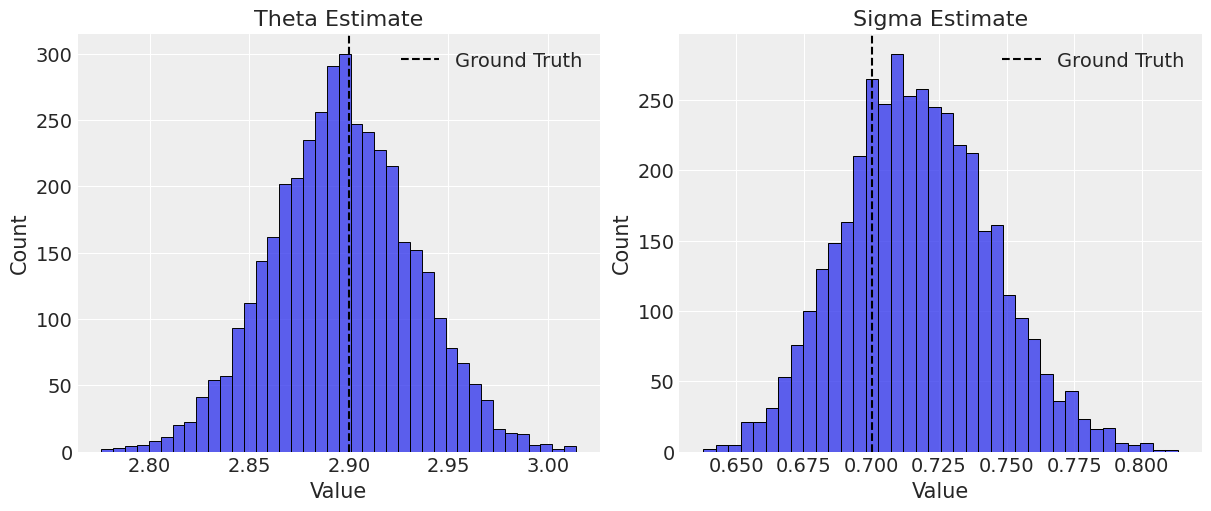

In [16]:
fig, ax = plt.subplots(1,2,figsize=(12,5))
sns.histplot( idata['theta'],ax=ax[0] )
ax[0].axvline(2.9,color='k', ls='--', label='Ground Truth')
ax[0].set(title="Theta Estimate", xlabel='Value')
ax[0].legend()

sns.histplot( idata['sigma'],ax=ax[1] )
ax[1].axvline(0.7,color='k', ls='--', label='Ground Truth')
ax[1].set(title="Sigma Estimate", xlabel='Value')
ax[1].legend()
plt.show()

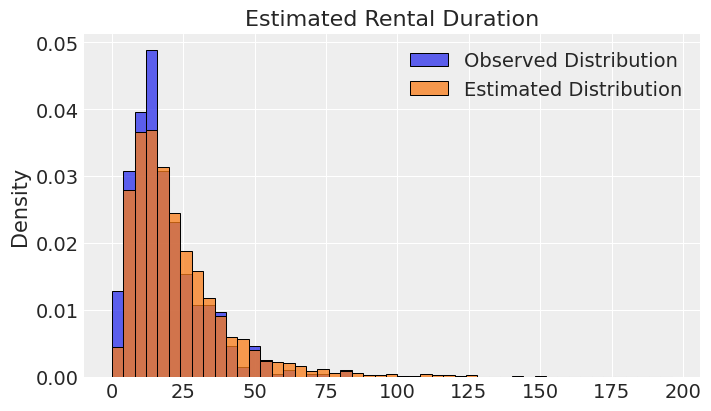

In [17]:
fig, ax = plt.subplots(1,1, figsize=(7,4))

bins = np.arange(0,200,4)
sns.histplot(T, stat='density', label='Observed Distribution', bins=bins,ax=ax)

sns.histplot(
    dist.LogNormal(idata['theta'], idata['sigma']).sample(jax.random.PRNGKey(1)),
    stat='density',
    label='Estimated Distribution',
    bins=bins,
    ax=ax
)
ax.set_title("Estimated Rental Duration")
ax.legend()
plt.show()

Great, now we have a rental duration model fit, we just need to estimate demand

## Rental Demand Model

---

### Looking at the demand data 

The rental demand model is going to start simple for this single-product case - we'll just estimate a poisson distribuion. 

Taking a look at the data again, its clear that demand is constrained, or censored, by stockouts here

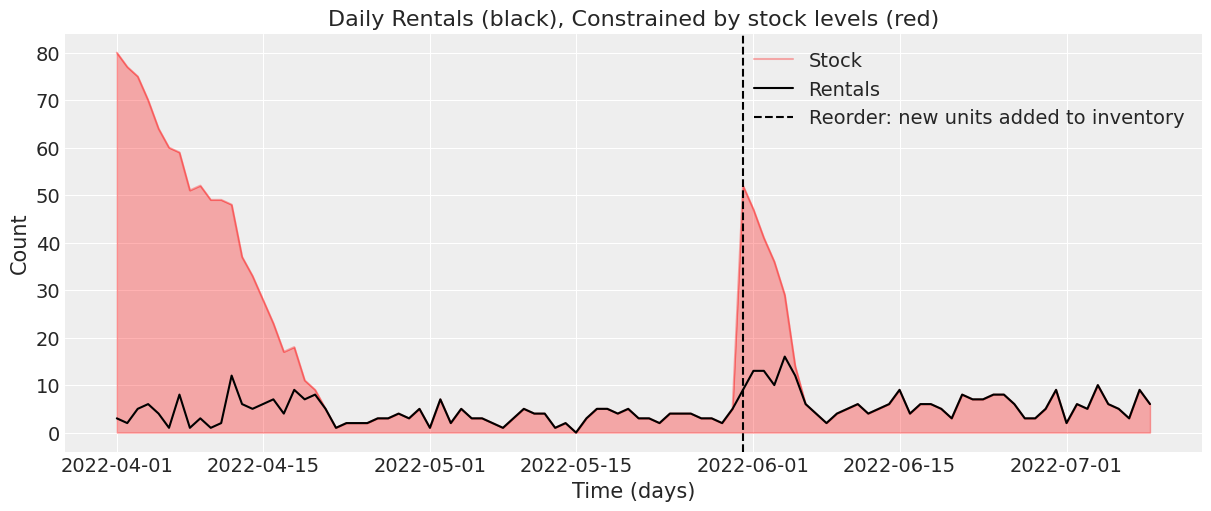

In [18]:
ax = plot_rentals(
    daily_rentals = daily_rentals.loc[f'product_{j}'].rentals, 
    daily_stock = daily_rentals.loc[f'product_{j}'].starting_units
)

ax.axvline(reorder_date, color='k', ls='--', label='Reorder: new units added to inventory')
plt.legend()
plt.show()

To confirm this is the case, we can take a look at the typical number of rentals when there is a stockout vs. when there isnt - its clear that demand is much less on days when there are stockouts - the sample size of stocked out periods is also very small

In [19]:
(
    daily_rentals
    .loc[f'product_{j}']
    .groupby("stockout")
    .rentals.agg(['mean', 'count'])
    .round(2)
)

,mean,count
stockout,,
0,6.65,26
1,4.31,74


### Defining and fitting the model


We can leverage survival analysis again to estimate demand. We define a censored poisson model below that assumes demand is constant over time and if theres a stockout, the model thinks that demand is atleast as high as the rentals that day, otherwise if there's no stockout it thinks that demand is the number of rentals that day (plus some noise of course)

In [20]:
def censored_poisson(lambd, cens, y=None):
    # If observed, this is the likelihood contribution
    numpyro.sample("obs", dist.Poisson(lambd).mask(cens != 1), obs=y)

    # If not observed, use the survival function as the likelihood constribution
    ccdf = 1 - dist.Poisson(lambd).cdf(y)
    pmf = jnp.exp(dist.Poisson(lambd).log_prob(y)) # need to include the pmf for discrete distributions
    numpyro.sample("censored_label", dist.Bernoulli(ccdf+pmf).mask(cens == 1), obs=cens)

def demand_model(stockout, X, y=None):

    # parameters
    alpha = numpyro.sample("alpha", dist.Normal(2, 2))
    beta = numpyro.sample("beta", dist.Normal(0, 1))

    with numpyro.plate("data", len(stockout)):

        # regression
        log_lambd = numpyro.deterministic(
            "log_lambd", 
            # base demand
            alpha 
            # covariate influence on demand - in this case cross product effect
            # as more products go out of stock, demand for the remaining in-stock products increases
            + jnp.dot( X, beta ) 
        )

        # demand as a rental rate per day
        lambd = numpyro.deterministic("lambd", jnp.exp(log_lambd))

        # Observational model
        censored_poisson(lambd, cens=stockout, y=y)

In [21]:
y = daily_rentals.loc[f'product_{j}'].rentals.values
stockout = daily_rentals.loc[f'product_{j}'].stockout.values
X = daily_rentals.loc[f'product_{j}'].total_stockout_rate.values
# X = (
#     daily_rentals
#     .assign(choices=lambda d: d.ending_units>0)
#     .assign(choices=lambda d: d.groupby("date").choices.transform("sum").shift())
#     .choices.fillna(1000).loc[f'product_{j}'].values
# )

kernel = numpyro.infer.NUTS(demand_model)
mcmc = numpyro.infer.MCMC(
    kernel,
    num_warmup=1000,
    num_samples=1000,
    num_chains=4,
    progress_bar=True,
)
mcmc.run(random.PRNGKey(SEED),stockout=stockout, X=X, y=y)
idata_demand = mcmc.get_samples()

/var/folders/vr/0jhy9tx52_s6tvbfbyppgn580000gn/T/ipykernel_58656/2649178842.py:12: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(
sample: 100%|█████████████████████████████| 2000/2000 [00:00<00:00, 9677.08it/s, 3 steps of size 5.04e-01. acc. prob=0.88]


we can check the estimated rental rate parameter, $\lambda$, against the actual value that we simulated and find that our model does have coverage over the ground truth

In [23]:
(
    pd.read_csv("data/true_params.csv")
    .assign(demand=lambda d: jax.nn.softmax(d.utility.values)*5000)
    .query(f"product_id=='product_{j}'")
)

,product_id,utility,demand
165,product_165,0.144032,3.841228


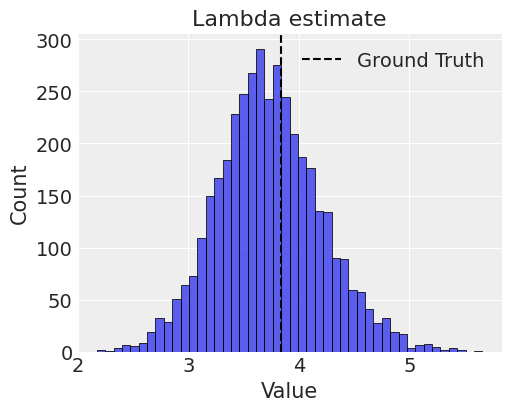

In [24]:
fig, ax = plt.subplots(figsize=(5,4))
sns.histplot( np.exp(idata_demand['alpha']),ax=ax )
ax.axvline(3.84, ls='--', color='k', label='Ground Truth')
ax.legend()
ax.set(xlabel="Value", title="Lambda estimate")
plt.show()

Ok cool, now that we have a rental duration model and a rental demand model, lets build a simulation

# Part 3: Simulation
---

## The simulation code

We can leverage numpyro to simulate this. They have a `scan` operator that basically iterates day over day which fits well with this problem. Here's the initial simulation model structure. 

If you look at the `model` method, it takes in an initial state, and iterates over the `model_single_day` method each day we tell it to. 

The `model_single_day` method simulates returns and rentals each day, and logs them.



```python
class RentalInventory:
	"""A model of rental inventory, modeling stock levels as returns and rentals occur each day.
	Currently supports a single product
	"""
	def __init__(self, n_products: int = 1, policies: np.ndarray = None):
		self.n_products = n_products
		self.policies = policies if policies is not None else np.zeros((n_products, 10000))
		# Rentals that are out with customers are stored as an array, where the index corresponds with time, 
		# and the value corresponds with the number of rentals from that time that are still out with customers
		# max_periods is the total number of periods to log
		self.max_periods = 10000

	def model(self, init_state: Dict, start_time: int, end_time: int) -> jnp.array:
		_, ys = scan(
			self.model_single_day, 
			init=init_state, 
			xs=jnp.arange(start_time, end_time)
		)
		return ys

	def model_single_day(self, state: Dict, time: int) -> Tuple[Dict, jnp.array]:
		state_next = dict()

		# Simulate Returns
		returns = self.returns_model(state['existing_rentals'], time)
		state_next['starting_stock'] = numpyro.deterministic("starting_stock", state['ending_stock']+returns.sum() + self.apply_policy(time))

		# Simulate Rentals, incorporate them into the next state
		rentals = self.demand_model(available_stock=state_next['starting_stock'], time=time)
		state_next['ending_stock'] = numpyro.deterministic("ending_stock", state_next['starting_stock'] - rentals.sum())
		state_next['existing_rentals'] = numpyro.deterministic("existing_rentals", state['existing_rentals'] - returns + rentals)
		return state_next, rentals

    ...
```

The individual models themselves are similar to what we've already used. They are a little complicated and overwhelming with the array operations and logic however, so feel free to skim over this for now.

```python
class RentalInventory
    
    ...
    
	def returns_model(self, existing_rentals: jnp.array, time: int) -> jnp.array:
		theta = numpyro.sample("theta", dist.Normal(2.9, 0.01))
		sigma = numpyro.sample("sigma", dist.TruncatedNormal(0.7, 0.01, low=0))
		return_dist = dist.LogNormal(theta, sigma)

		# Calculate the discrete hazard of rented out inventory from previous time-points being returned
		discrete_hazards = self.survival_convolution(dist=return_dist, time=time)

		# Simulate returns from hazards
		returns = numpyro.sample("returns", dist.Binomial(existing_rentals.astype("int32"), probs=discrete_hazards))
		total_returns = numpyro.deterministic("total_returns", returns.sum())
		return returns

	def demand_model(self, available_stock, time):
		lambd = numpyro.sample("lambd", dist.Normal(10, 0.01))
		unconstrained_rentals = numpyro.sample("unconstrained_rentals", dist.Poisson(lambd))
		rentals = numpyro.deterministic("rentals", jnp.clip(unconstrained_rentals, a_min=0, a_max=available_stock ))
		rentals_as_arr = ( time == jnp.arange(self.max_periods) )*rentals
		return rentals_as_arr

	def survival_convolution(self, dist, time: int) -> jnp.array:
		"""Calculates the hazard rate of a return from all past time periods, returning an array where each index is a previous time period,
		and the value is the probability of a rental from that time being returned at the current date.
		"""
		rental_durations = (time-jnp.arange(self.max_periods))
		discrete_hazards = jnp.where(
			# If rental duration is nonnegative,
			rental_durations>0,
			# Use those rental durations to calculate a return rate, using a discrete interval hazard function
			RentalInventory.hazard_func(jnp.clip(rental_durations, a_min=0), dist=dist ),
			# Otherwise, return rate is 0
			0
		)
		return discrete_hazards

	@staticmethod
	def hazard_func(t, dist):
		"""Discrete interval hazard function - aka the probability of a return occurring on a single date
		"""
		return (dist.cdf(t+1)-dist.cdf(t))/(1-dist.cdf(t))

	def apply_policy(self, time):
        """Adds in some number of units for the product at time $T=t$
        """
		return self.policies[time]
```

## Simulating the impact of reordering more units

Lets dive in and simulate what would happen if we re-stocked different amounts

In [25]:
def get_active_rentals_as_array(rentals):
    """Each array element corresponds to a single day, and the value is the amount of active rentals that are still
    out with customers that started on that date
    """
    active_rentals = np.zeros(10000)
    dates = pd.date_range(rentals.date.min(), end=rentals.date.max(), freq='D').values
    active_rentals[:len(dates)] = (rentals.loc[lambda d: d.return_date.isnull()].date.values == dates[:,None]).sum(1)
    return active_rentals

def reorder_as_array(reorder_amount, reorder_time, max_periods=10000):
    return (jnp.arange(max_periods) == reorder_time)*reorder_amount

In [26]:
from censored_demand.rental_model import RentalInventory

latest_stock_level = daily_rentals.query(f"product_id=='product_{j}'").tail(1)['ending_units'].values[0]
active_rentals = get_active_rentals_as_array(rentals.query(f"product_id=='product_{j}'"))
init_state = {
    "starting_stock": jnp.array([latest_stock_level]),
    "ending_stock": jnp.array([latest_stock_level]),
    "existing_rentals":active_rentals[:,None].T
}

# Try adding 150 new units at time T=100
reorder_policy = reorder_as_array(150, reorder_time=100)[None,:]

rental_inventory = PoissonDemandInventory(n_products = 1, policies=reorder_policy)

nsamples =250
simulation = numpyro.infer.Predictive(
    rental_inventory.model, 
    num_samples = nsamples,
    # Input our learned parameters from the previous models
    posterior_samples={
        "lambd":idata_demand['lambd'][:nsamples,[-1]], 
        "theta":idata['theta'][:nsamples,None],
        "sigma":idata['sigma'][:nsamples,None]
    }

)
results = simulation(random.PRNGKey(SEED), init_state, start_time=100, end_time=200)

Lets look at one potential outcome of the simulation. You can try re-running this multiple times to see a range of possible different outcomes that are all possible under this reorder policy. Most of these end up still being stocked out

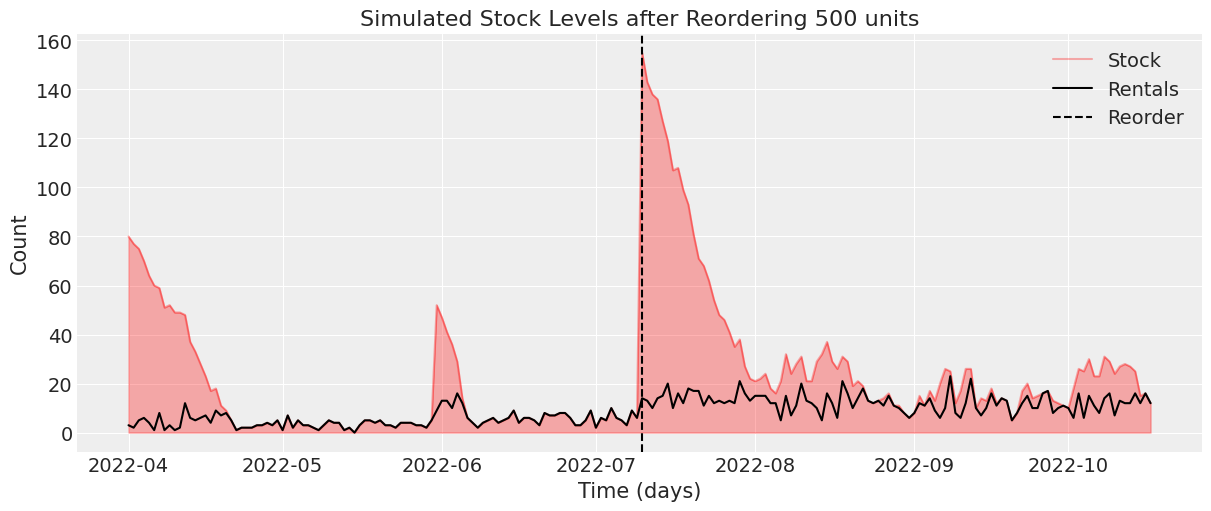

In [27]:
sample_idx = np.random.choice(250)

historical_data = daily_rentals.loc[f'product_{j}']
sim_dates = pd.date_range( historical_data.index[-1], periods=results['rentals'].shape[1]+1)
sim_data = pd.Series(results['rentals'][sample_idx,:].ravel(),  index= sim_dates[1:] )

daily_rentals_j = pd.concat((historical_data.rentals, sim_data))
daily_stock_j = np.concatenate((daily_rentals.loc[f'product_{j}'].starting_units.values, results['starting_stock'][sample_idx,:].squeeze(-1)))

ax = plot_rentals(daily_rentals_j, daily_stock_j)
ax.set(title='Simulated Stock Levels after Reordering 500 units')
ax.axvline(daily_rentals_j.index.values[100], color='k', ls='--', label='Reorder')
ax.legend()
plt.show()

We can summarize all of these simulations with uncertainty intervals 

/Users/kylejcaron/Library/Caches/pypoetry/virtualenvs/censored-demand-2hs-RL0I-py3.10/lib/python3.10/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


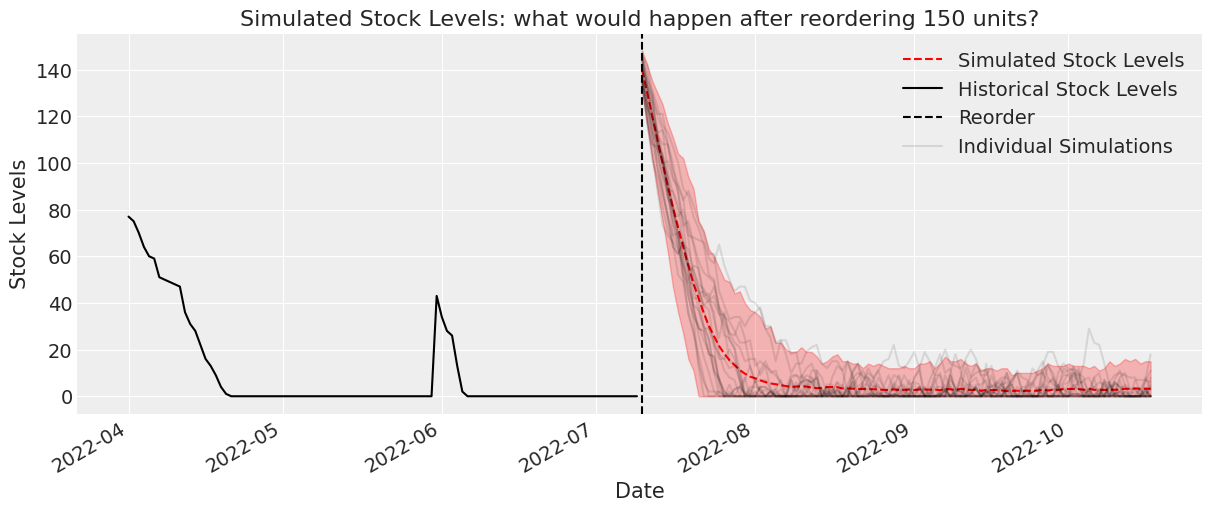

In [28]:
dates = pd.date_range(start=rentals.date.min(), periods=200, freq='D')


daily_ending_stock_sim = results['ending_stock'].squeeze(-1)

fig, ax = plt.subplots(1,1,figsize=(12,5))
az.plot_hdi(dates[100:], daily_ending_stock_sim, smooth=False,ax=ax, color='r', fill_kwargs=dict(alpha=0.25),)
ax.plot(dates[100:], daily_ending_stock_sim.mean(0), color='r', ls='--', label='Simulated Stock Levels')
historical_data.ending_units.plot(color='k',ax=ax, label='Historical Stock Levels')
ax.axvline(dates[100], color='k',ls='--', label='Reorder')
ax.set(
    title='Simulated Stock Levels: what would happen after reordering 150 units?',
    ylabel='Stock Levels',
    xlabel='Date'
)

# Overlay some simulations to confirm its lining up with the plot
ax.plot(dates[100:], daily_ending_stock_sim[:20,:].T, alpha=0.1, color='k');
ax.plot(dates[100:], daily_ending_stock_sim[0,:].T, alpha=0.1, color='k',label='Individual Simulations');

ax.legend()
plt.show()

This view makes it a little more clear that there are probably stockouts happening, but it doesnt tell us for sure. 
We can actually calculate the stockout rate over time by averaging over all of the existing simulations and counting the number of simulations that have 0 stock each day.

We could also go back and update the simulator to log things like *"missed rentals due to stockouts"* or other quantities that might be helpful

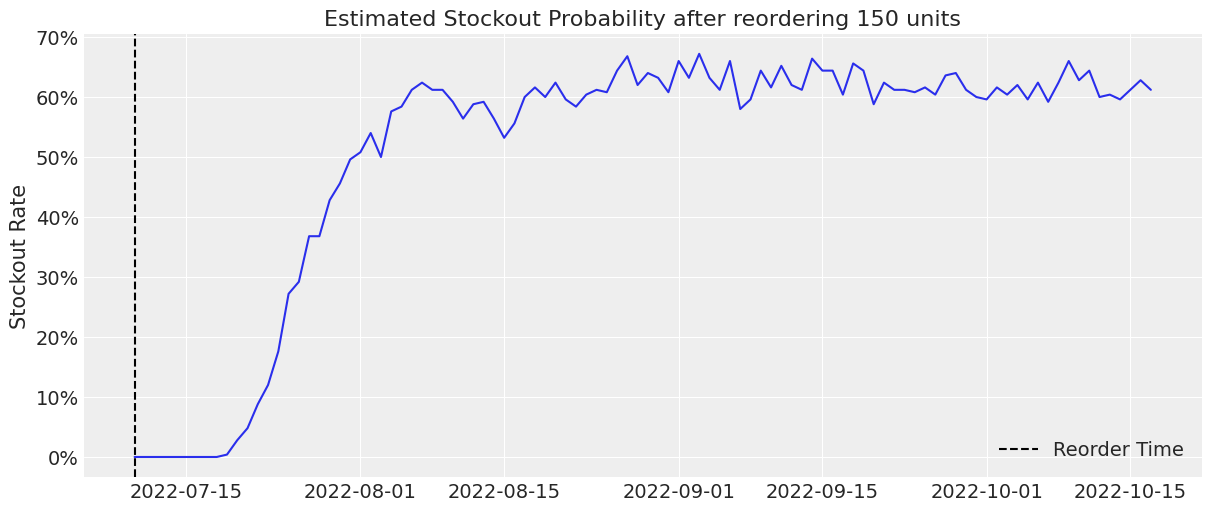

In [29]:
fig, ax = plt.subplots(1,1,figsize=(12,5))
p_stockout = (daily_ending_stock_sim==0).mean(0)
ax.plot(dates[100:200], p_stockout)
ax.axvline(dates[100], color='k', ls='--', label='Reorder Time')
ax.set(title='Estimated Stockout Probability after reordering 150 units', ylabel='Stockout Rate')
ax.legend()
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1,0))
plt.show()

Ok so clearly reordering 150 units isnt enough - so what should we reorder? 

We could just simulate repeatedly with different stock reorder inputs like below

In [30]:
def sim_stockout_rate(stock_reorder, samples_per_iter=250):    
    
    latest_stock_level = daily_rentals.query(f"product_id=='product_{j}'").tail(1)['ending_units'].values[0]
    active_rentals = get_active_rentals_as_array(rentals.query(f"product_id=='product_{j}'"))
    init_state = {
        "starting_stock": jnp.array([latest_stock_level]),
        "ending_stock": jnp.array([latest_stock_level]),
        "existing_rentals":active_rentals[None,:]
    }

    # Try adding x new units at time T=100
    reorder_policy = reorder_as_array(stock_reorder, reorder_time=100)[None,:]
    rental_inventory = PoissonDemandInventory(n_products = 1, policies=reorder_policy)

    simulation = numpyro.infer.Predictive(
        rental_inventory.model, 
        num_samples = samples_per_iter,
        # Input our learned parameters from the previous models
        posterior_samples={
            "lambd": idata_demand['lambd'][:samples_per_iter,[-1]], 
             "theta": idata['theta'][:samples_per_iter,None],
             "sigma": idata['sigma'][:samples_per_iter,None]
        }
    )
    results = simulation(random.PRNGKey(SEED), init_state, start_time=100, end_time=200)
    # Only going to care about instock rate for the second half of the simulation to be safe
    burn_in = 50
    stockout_rate = (results['ending_stock']==0).mean(0)[burn_in:].mean()
    
    return stockout_rate

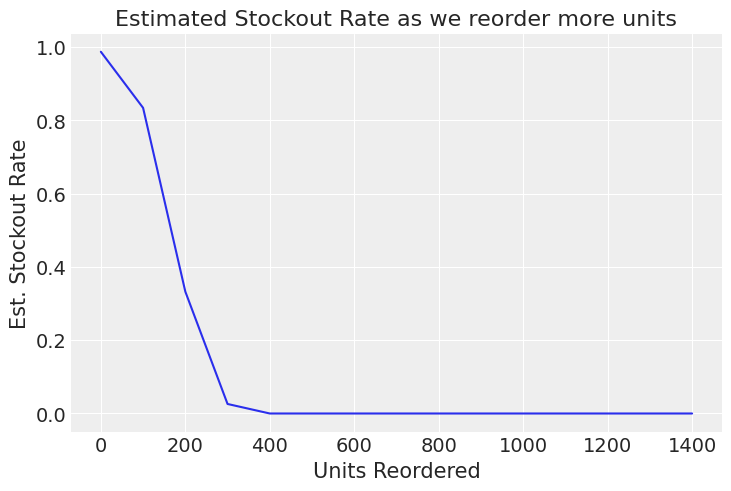

In [31]:
stockout_results = np.empty((15,2))
for i, units in enumerate(range(0,1500, 100)):
    stockout_rate = sim_stockout_rate(units)
    stockout_results[i,:] = [units, stockout_rate]

fig, ax = plt.subplots()
ax.plot(stockout_results[:,0], stockout_results[:,1])
ax.set(ylabel='Est. Stockout Rate', xlabel='Units Reordered', title='Estimated Stockout Rate as we reorder more units')
plt.show()

Its clear that right around 350 units is when the probability of a stockout gets really low. We could speed this up if we wanted by building an optimizer. One simple way might be to build a binary search algorithm that gets you the minimum amount of stock without having any stockouts.

Thats an exercise for another time. Lets reorder 1300 units like we're recommending and see what happens

In [32]:
active_rentals = np.zeros((1000,10000))
for i in range(1000):
    active_rentals[i] = get_active_rentals_as_array(rentals.query(f"product_id=='product_{i}'"))

init_state = {
    "starting_stock": jnp.array(stock.loc[lambda d: d.date==d.date.max()].ending_units.values),
    "ending_stock": jnp.array(stock.loc[lambda d: d.date==d.date.max()].ending_units.values),
    "existing_rentals": jnp.array(active_rentals)
}


# Try adding x new units at time T=100
reorder_policy = jnp.zeros((1000, 10000)).at[j,100].set(350)
rental_inventory = MultinomialDemandInventory(n_products = 1000, policies=reorder_policy)

# only simulate 1 sample - we're going to use the true data generating process 
# to pretend we actually reordered 100 units and watched what happened afterward
observe_future = numpyro.infer.Predictive(
    rental_inventory.model, 
    num_samples = 1,
    
)
results = observe_future(random.PRNGKey(SEED), init_state, start_time=100, end_time=200)


[autoreload of censored_demand.plotting failed: Traceback (most recent call last):
  File "/Users/kylejcaron/Library/Caches/pypoetry/virtualenvs/censored-demand-2hs-RL0I-py3.10/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/Users/kylejcaron/Library/Caches/pypoetry/virtualenvs/censored-demand-2hs-RL0I-py3.10/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
  File "/Users/kylejcaron/.pyenv/versions/3.10.7/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 879, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1017, in get_code
  File "<frozen importlib._bootstrap_external>", line 947, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_

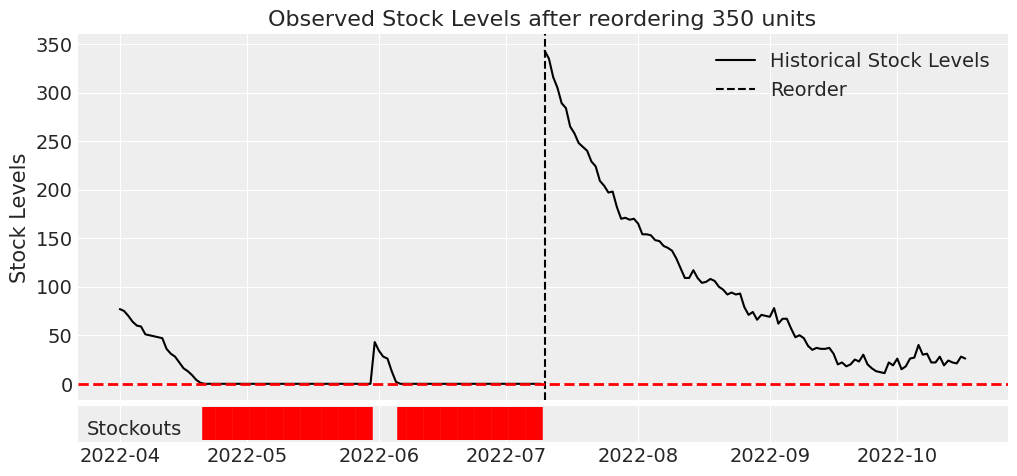

In [69]:
gs_kw = dict(width_ratios=[15], height_ratios=[10,1])

fig, axes = plt.subplots(ncols=1, nrows=2, constrained_layout=False, gridspec_kw=gs_kw, sharex=True, figsize=(12,6))

daily_ending_stock = results['ending_stock'][..., j].squeeze()
historical_ending_stock = daily_rentals.loc[f'product_{j}'].ending_units


axes[0].plot(dates[100:], daily_ending_stock, color='k')
historical_ending_stock.plot(color='k',ax=axes[0], label='Historical Stock Levels')
axes[0].axvline(dates[100], color='k',ls='--', label='Reorder')
axes[0].set(
    title='Observed Stock Levels after reordering 350 units',
    ylabel='Stock Levels',
    xlabel='Date'
)
# axes[0].set_ylim(-2,100)
axes[0].axhline(0, color='r', lw=2, ls='--')
axes[0].legend()


# plot stockouts
axes[-1].vlines(dates[:100][(historical_ending_stock==0).values],0,1, color='r', lw=4)
axes[-1].vlines(dates[100:][(daily_ending_stock==0)],0,1, color='r', lw=4)
axes[-1].set_yticks([])

axes[-1].annotate("Stockouts", xy=(0.01, 0.2),xycoords='axes fraction', fontsize=14)

fig.subplots_adjust(hspace=0.025)

Amazing, by reordering 350 units, we no longer ran into any stockouts! This is exactly what we were hoping for. 

We now have a system we can use to figure out the optimal stock to reorder for a single product. How can we now scale this to our entire inventory, or even inform the purchasing of new products?

# Next Steps: Simulating a full product assortment

---

We're going to borrow ideas from discrete choice literature (see [Kenneth Train's Discrete Choice Methods with Simulation](https://eml.berkeley.edu/books/choice2.html)) - each product has some inherent utility, $U$, which determines how often its chosen. 

A decision maker, $n$, has $J$ products they can choose from. The utility of a given product, $j$ for a given user $n$ is 

$$
U_{nj} \sim \beta \: x_{nj} + \epsilon_{nj}
$$

where $\epsilon_{nj}$ is an error term that follows a Gumbel distribution. Date effects can also be added, for instance sweaters may have higher utility in the winter. We'll keep it simple for now and avoid date effects

Why are we using this seemingly complicated representation? It has some really nice properties - namely that utilities are easy to convert to choice probabilities, even when the choice set (in this case the available product catalog) changes. All you have to do is take your utilities and feed them into a softmax equation to get choice probabilities for each product.

This is particularly helpful for this sort of problem, because the choice set is frequently changing for customers as products go in and out of stock.

We're going to make one key simplification here - we're going to measure utility for the population as a whole, and not condition on individual user features - since our goal right now is just to know how much stock to reorder, we dont really need to know heterogeneity in demand across users unless we expect a big shift in our customer mix in the near term. 


[To be continued]

In [68]:
class MultinomialDemandInventory(RentalInventory):
    """A model of rental inventory, modeling stock levels as returns and rentals occur each day.
    Currently supports a single product
    """
    def __init__(self, n_products: int = 1, policies: np.ndarray = None):
        super().__init__(n_products, policies)
    
    def demand_model(self, available_stock, time):
        """Models the true demand each day.
        """
        # Hyperparameters
        lambd_total = numpyro.sample("lambd", dist.Normal(5000, 0.01))
        with numpyro.plate("n_products", self.n_products):
            utility = numpyro.sample("utility", dist.Gumbel(0, 0.5))
        
        # Generative model
        total_rentals = numpyro.sample("total_rentals", dist.Poisson(lambd_total))

        # Log measures of unconstrained demand
        avl_idx = jnp.where(available_stock>0, 1, 0)
        p_j = jax.nn.softmax(utility, where=avl_idx, initial=0)
        _ = numpyro.deterministic("unconstrained_demand", self.total_rental_rate * p_j)
        _ = numpyro.sample("unconstrained_rentals", dist.Multinomial(self.total_rental_rate, p_j))

        # Simulate from censored multinomial
        rentals = numpyro.deterministic("rentals", 
                    RentalInventory.censored_multinomial(n=total_rentals, U_j=utility, stock_j=available_stock)
        )
        rentals_as_arr = ( time == jnp.arange(self.max_periods) )*rentals[:,None]
        return rentals_as_arr.astype(int)


In [26]:
rental_model = MultinomialDemandInventory(n_products=2000)
stock0_j = jnp.ones((2000))*100
sample_fn = numpyro.infer.Predictive(rental_model.demand_model, num_samples=10)
res = sample_fn(random.PRNGKey(1), stock0_j, 11)
res['rentals'].sum(1)

Array([5071., 4832., 5058., 4995., 4979., 4910., 4920., 5161., 5066.,
       5098.], dtype=float32)

[in progress]

In [27]:
# latest_stock_level = stock.tail(1)['units'].values[0]
# active_rentals = get_active_rentals_as_array(rentals)
# init_state = {
#     "starting_stock": latest_stock_level,
#     "ending_stock": latest_stock_level,
#     "existing_rentals":active_rentals
# }


# T = 100
# j_products = 2
# # rental_inventory = PoissonDemandInventory(n_products=1)
# init_state = {
#     "starting_stock":jnp.ones((j_products))*100,
#     "ending_stock":jnp.ones((j_products))*100,
#     # No pre-existing rentals for this product at the start of the simulation
#     "existing_rentals": jnp.zeros((j_products,10000)),
# }

# # The product had a reorder, where 50 new units were added at time t=40
# reorder_policy = (jnp.arange(T) == 40)[:,None].T*50

# # Simulate demand and stock for the product
# rental_inventory= PoissonDemandInventory(n_products=j_products, policies=None)
# pred_fn = numpyro.infer.Predictive(
#     rental_inventory.model, 
#     num_samples = 1,
# )
# results = pred_fn(jax.random.PRNGKey(0), init_state, 0, T)
# # stock_data, rental_events = make_pseudo_rental_data(results, start_date = '2022-04-01')



In [ ]:
# T = 100
# j_products = 25
# rental_model = PoissonDemandInventory(n_products=j_products)
# initial_depth = np.random.choice(range(50,250,5), size=j_products)

# init_state = {
#     "starting_stock":initial_depth,
#     "ending_stock":jnp.ones((j_products))*100,
#     # No pre-existing rentals for this product at the start of the simulation
#     "existing_rentals": np.zeros((j_products,10000)),
# }

# # The products had a reorder at t=40
# reorder_amt = np.random.choice(range(0,160,10), size=j_products)
# reorder_policy = (jnp.arange(T) == 40)*reorder_amt[:,None]

# # Simulate demand and stock for the product
# rental_inventory= PoissonDemandInventory(n_products=j_products, policies=reorder_policy)
# pred_fn = numpyro.infer.Predictive(
#     rental_inventory.model, 
#     num_samples = 1,
# )
# results = pred_fn(jax.random.PRNGKey(2), init_state, 0, T)

In [133]:
def simulate_buy_amounts(utility, j_products, min_buy=20, max_buy=300):
    """This function simulates semi-informed buy amounts - 80% the time the buy is correlated to utility (but typically underbought)
    and the rest of the time the buy is randomly informed
    """
    X = np.random.gamma( utility+np.abs(utility.min()) + 5 ,0.2,size=j_products)
    semi_informed_depth=(min_buy + X/X.max()*max_buy) // 10*10

    is_informed_buy = np.random.binomial(1, 0.8, size=j_products)
    random_depth = np.random.choice(range(min_buy, max_buy+1,10), size=j_products)
    buy_amounts = np.where(is_informed_buy==True, semi_informed_depth, random_depth)
    return buy_amounts
    


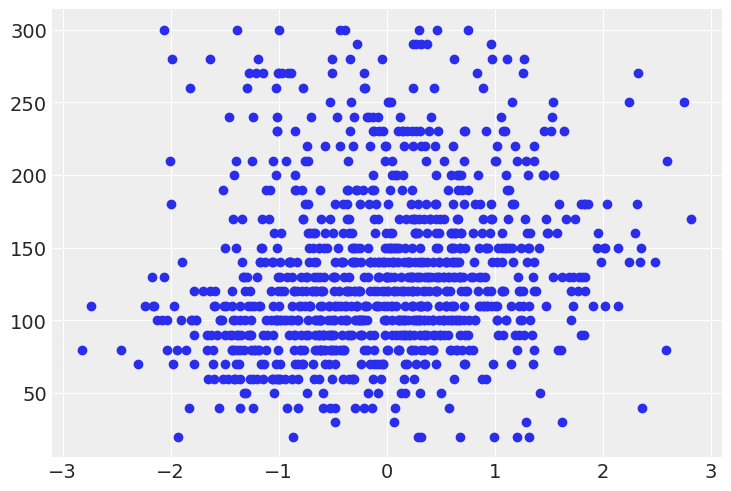

In [134]:
plt.scatter(rental_inventory.U,  simulate_buy_amounts(rental_inventory.U, j_products))

<Axes: ylabel='Count'>

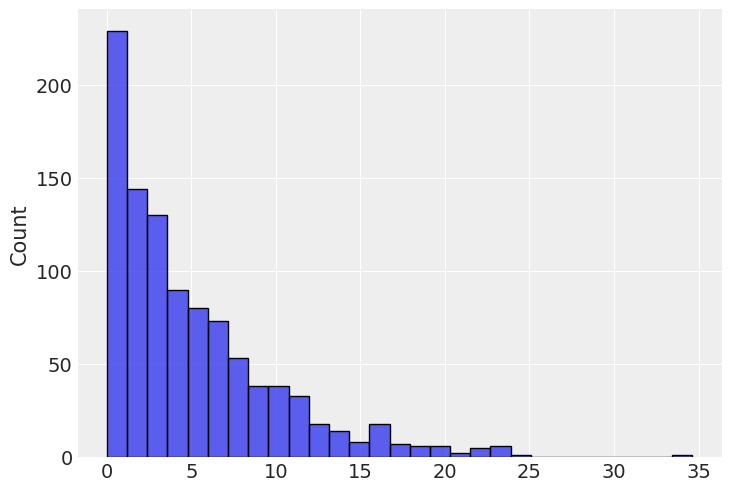

In [104]:
sns.histplot( 5 * rng.exponential( size=j_products) )

In [85]:
from censored_demand.rental_model import MultinomialDemandInventory

T = 100
j_products = 1000

# 20% of the products had a reorder at t=60
rng = np.random.default_rng(seed=SEED)
reorder_amt = rng.choice(range(0,150+1,50), p=[0.8, 0.1,0.05,0.05], size=j_products)
reorder_policy = (jnp.arange(T) == 60)*reorder_amt[:,None]

rental_inventory= MultinomialDemandInventory(n_products=j_products, policies=reorder_policy)
initial_depth = simulate_buy_amounts(rental_inventory.U, j_products)


# 20% of the products had a reorder at t=60
rng = np.random.default_rng(seed=SEED)
reorder_amt = rng.choice(range(0,150+1,50), p=[0.8, 0.1,0.05,0.05], size=j_products)
reorder_policy = (jnp.arange(T) == 60)*reorder_amt[:,None]


init_state = {
    "starting_stock": jnp.array(initial_depth),
    "ending_stock": jnp.array(initial_depth),
    # No pre-existing rentals for this product at the start of the simulation
    "existing_rentals": jnp.zeros((j_products,10000)),
}



# Simulate demand and stock for the product
pred_fn = numpyro.infer.Predictive(
    rental_inventory.model, 
    num_samples = 1,
)
results = pred_fn(jax.random.PRNGKey(2), init_state, 0, T)

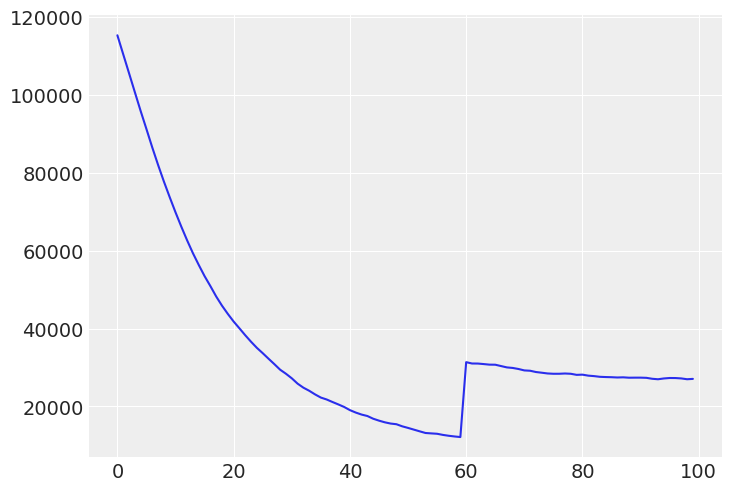

In [86]:
plt.plot( results['ending_stock'].squeeze(0).sum(1) )

/var/folders/vr/0jhy9tx52_s6tvbfbyppgn580000gn/T/ipykernel_53363/572868178.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  instock = (pd.DataFrame(results['ending_stock'].squeeze(0),index=dates[:100])>0).resample("M").mean()


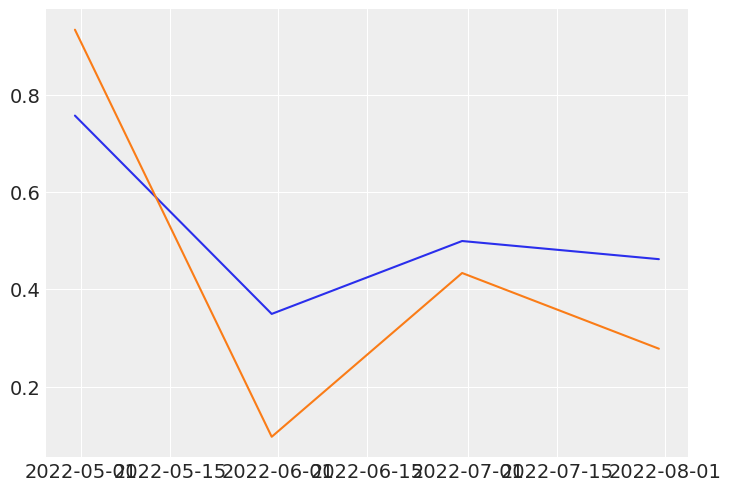

In [87]:
instock = (pd.DataFrame(results['ending_stock'].squeeze(0),index=dates[:100])>0).resample("M").mean()

plt.plot(instock.index, np.mean(instock,axis=1) )
plt.plot(instock.index, np.median(instock,axis=1) )


In [ ]:
def censored_multinomial(n, U_j, stock_j):
    stock = stock_j.copy()
    results = np.zeros(stock_j.shape[0])
    for rental in range(n):
        avl_idx = np.where(stock>0)[0]
        p_j = sp.softmax( U_j[avl_idx] )
        choice = np.random.choice(avl_idx, p=p_j)
        results += 1*(np.arange(stock_j.shape[0])==choice)
        stock -= 1*(np.arange(stock_j.shape[0])==choice)
        avl_idx = np.where(stock>0)[0]
    return results

def censored_multinomial(n, U_j, stock_j):
    """This implements a series of multinomial choices under inventory constraints
    """
    stock = stock_j.copy()
    results = np.zeros(stock_j.shape[0])
    
    while n > 0:
        avl_idx = np.where(stock>0)[0]
        p_j = sp.softmax( U_j[avl_idx] )
        choices = np.zeros(stock.shape)
        choices[avl_idx] = np.random.multinomial(n=min(stock[avl_idx].min(), n), pvals=p_j)
        results += choices
        stock -= choices            
        n -= choices.sum()

    return results

def censored_multinomial(n, U_j, stock_j):
    """This implements a series of multinomial choices under inventory constraints
    """
    eps=1e-10

    stock = stock_j.copy()
    results = jnp.zeros(stock_j.shape[0])
    
    while n > 0:
        avl_idx = jnp.where(stock>0, 1, 0)
        p_j = jax.nn.softmax(U_j, where=avl_idx, initial=0)
        nchoices = int(min(stock[avl_idx==1].min(), n))
        choices = jax.random.categorical(random.PRNGKey(1), np.log(p_j+eps), shape=(nchoices,))
        choices = (choices == jnp.arange(stock.shape[0])[:,None]).sum(1)
        results += choices
        stock -= choices            
        n -= choices.sum()
    return results